# Classification of emotions

## Importing the libraries

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Loading the images

In [5]:
path = 'fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

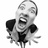

In [6]:
tf.keras.preprocessing.image.load_img('fer2013/train/Angry/1003.jpg')

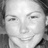

In [8]:
image = tf.keras.preprocessing.image.load_img('fer2013/train/Happy/1.jpg')
image

### Train and test set

In [9]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('fer2013/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.


In [10]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6])

In [11]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171], dtype=int64))

In [12]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

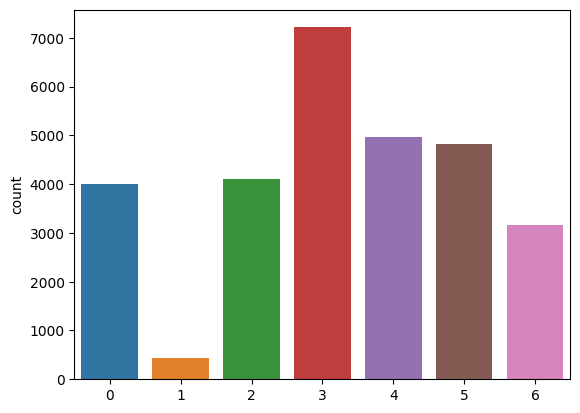

In [13]:
sns.countplot(x = train_dataset.classes);

In [14]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

In [ ]:
2*2*2*32

256

In [18]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 5

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [22]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
network.fit(train_dataset, epochs=epochs)

Epoch 1/5
1795/1795 [==============================] - 290s 160ms/step - loss: 1.8636 - accuracy: 0.2658
Epoch 2/5
1795/1795 [==============================] - 228s 127ms/step - loss: 1.5364 - accuracy: 0.4025
Epoch 3/5
1795/1795 [==============================] - 228s 127ms/step - loss: 1.3806 - accuracy: 0.4713
Epoch 4/5
1795/1795 [==============================] - 228s 127ms/step - loss: 1.3046 - accuracy: 0.5078
Epoch 5/5
1795/1795 [==============================] - 227s 126ms/step - loss: 1.2533 - accuracy: 0.5293


## Saving and loading the model

In [24]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [25]:
from keras.models import save_model
network_saved = save_model(network, 'weights_emotions.hdf5')

C:\Users\ieguser\AppData\Local\Temp\ipykernel_5192\2599276311.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, 'weights_emotions.hdf5')


In [26]:
with open('network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 48, 48, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null,

In [27]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [28]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

## Model evaluation

In [29]:
network_loaded.evaluate(test_dataset)

3589/3589 [==============================] - 24s 7ms/step - loss: 1.4102 - accuracy: 0.5015


[1.4101645946502686, 0.5015324354171753]

In [30]:
predictions = network_loaded.predict(test_dataset)
predictions

3589/3589 [==============================] - 16s 4ms/step


array([[1.6947749e-01, 1.8220820e-02, 2.6272973e-01, ..., 2.0203973e-01,
        3.1791982e-01, 2.7976049e-02],
       [5.1471901e-01, 5.7262398e-02, 2.8832066e-01, ..., 1.7285695e-02,
        4.4682343e-02, 3.0486684e-02],
       [7.0077717e-01, 7.9992101e-02, 7.0902973e-02, ..., 6.1903257e-02,
        6.5601885e-02, 2.3266627e-03],
       ...,
       [9.9013355e-03, 6.1760918e-04, 8.9821957e-02, ..., 5.2017332e-03,
        3.0390483e-03, 8.8886291e-01],
       [4.2150352e-02, 1.2623385e-03, 1.3670957e-01, ..., 1.9171692e-01,
        3.2179777e-02, 5.8674419e-01],
       [3.0459104e-02, 9.5052790e-04, 7.7095240e-02, ..., 2.6253372e-02,
        1.7160838e-02, 8.0128974e-01]], dtype=float32)

In [31]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([5, 0, 0, ..., 6, 6, 6], dtype=int64)

In [32]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6])

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.5015324602953469

In [34]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[161,   6,  39,  43, 108, 103,  31],
       [ 15,   7,   9,   3,   5,  13,   3],
       [ 38,   5,  90,  56,  80, 134, 125],
       [  3,   1,  12, 771,  29,  35,  28],
       [ 58,   1,  43, 172, 141, 122,  89],
       [ 17,   0,  38,  71, 145, 306,  17],
       [  4,   0,  22,  34,  21,  11, 324]], dtype=int64)

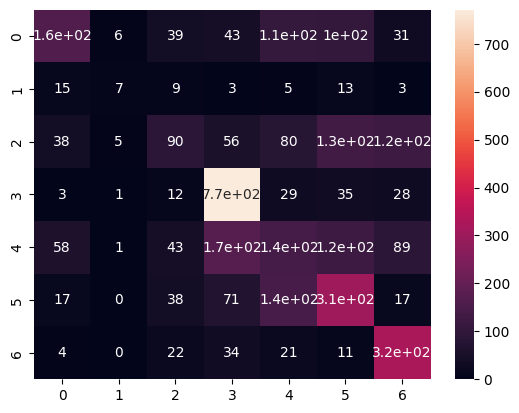

In [36]:
sns.heatmap(cm, annot=True);

In [37]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.54      0.33      0.41       491
           1       0.35      0.13      0.19        55
           2       0.36      0.17      0.23       528
           3       0.67      0.88      0.76       879
           4       0.27      0.23      0.24       626
           5       0.42      0.52      0.46       594
           6       0.53      0.78      0.63       416

    accuracy                           0.50      3589
   macro avg       0.45      0.43      0.42      3589
weighted avg       0.47      0.50      0.47      3589



## Classifying one single image

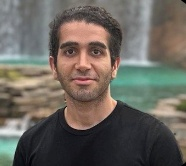

In [51]:
from IPython.display import display

image = cv2.imread('image1.jpg')

#Image(filename='image1.jpg')
display(Image(data=cv2.imencode('.jpg', image)[1].tobytes()))


In [45]:
image.shape

(166, 186, 3)

In [46]:
face_detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')

In [47]:
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)

In [48]:
faces

array([[ 44,  21,  78,  78],
       [107,  50,  57,  57]])

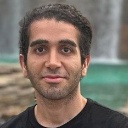

In [72]:
roi_ = image[2:2 + 128, 30:30 + 128]

display(Image(data=cv2.imencode('.jpg', roi_)[1].tobytes()))


In [73]:
roi_.shape

(128, 128, 3)

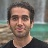

In [74]:
roi = cv2.resize(roi_, (48, 48))
display(Image(data=cv2.imencode('.jpg', roi)[1].tobytes()))

In [75]:
roi.shape

(48, 48, 3)

In [76]:
roi

array([[[ 95, 102, 101],
        [ 97, 100,  99],
        [105, 106, 106],
        ...,
        [145, 143, 141],
        [107, 110, 109],
        [ 88,  95,  98]],

       [[ 93, 100,  99],
        [ 98, 101, 100],
        [105, 105, 104],
        ...,
        [134, 134, 133],
        [102, 106, 106],
        [ 87,  94,  99]],

       [[ 98, 103, 103],
        [103, 105, 105],
        [107, 107, 106],
        ...,
        [130, 134, 132],
        [ 96, 103, 102],
        [ 84,  93,  96]],

       ...,

       [[104, 107, 110],
        [105, 104, 105],
        [ 78,  75,  76],
        ...,
        [ 59,  57,  57],
        [ 53,  51,  52],
        [ 60,  59,  59]],

       [[107, 105, 106],
        [ 79,  77,  73],
        [ 64,  61,  57],
        ...,
        [ 54,  52,  52],
        [ 52,  50,  50],
        [ 64,  62,  62]],

       [[ 59,  55,  55],
        [ 70,  64,  65],
        [ 58,  53,  53],
        ...,
        [ 49,  47,  46],
        [ 53,  51,  51],
        [ 46,  46,  46]]

In [77]:
roi = roi / 255
roi

array([[[0.37254902, 0.4       , 0.39607843],
        [0.38039216, 0.39215686, 0.38823529],
        [0.41176471, 0.41568627, 0.41568627],
        ...,
        [0.56862745, 0.56078431, 0.55294118],
        [0.41960784, 0.43137255, 0.42745098],
        [0.34509804, 0.37254902, 0.38431373]],

       [[0.36470588, 0.39215686, 0.38823529],
        [0.38431373, 0.39607843, 0.39215686],
        [0.41176471, 0.41176471, 0.40784314],
        ...,
        [0.5254902 , 0.5254902 , 0.52156863],
        [0.4       , 0.41568627, 0.41568627],
        [0.34117647, 0.36862745, 0.38823529]],

       [[0.38431373, 0.40392157, 0.40392157],
        [0.40392157, 0.41176471, 0.41176471],
        [0.41960784, 0.41960784, 0.41568627],
        ...,
        [0.50980392, 0.5254902 , 0.51764706],
        [0.37647059, 0.40392157, 0.4       ],
        [0.32941176, 0.36470588, 0.37647059]],

       ...,

       [[0.40784314, 0.41960784, 0.43137255],
        [0.41176471, 0.40784314, 0.41176471],
        [0.30588235, 0

In [78]:
roi.shape

(48, 48, 3)

In [79]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [80]:
probs = network_loaded.predict(roi)
probs

1/1 [==============================] - 0s 22ms/step


array([[0.14768338, 0.0020143 , 0.10562705, 0.03917271, 0.42728972,
        0.25258362, 0.02562921]], dtype=float32)

In [81]:
result = np.argmax(probs)
result

4

In [89]:
categories = test_dataset.class_indices
categories

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

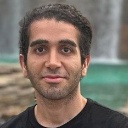

Prediction:  Neutral


In [91]:
display(Image(data=cv2.imencode('.jpg', roi_)[1].tobytes()))
for key, val in categories.items():
    if val == result:
        detected_emotion = key
print('Prediction: ', detected_emotion)

## Classifying multiple images

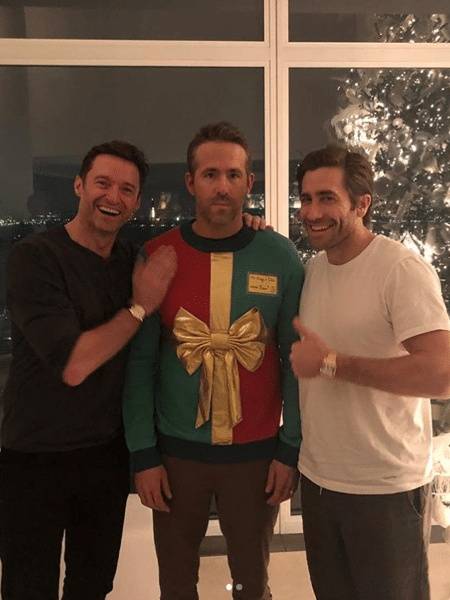

In [92]:
image = cv2.imread('multiple_faces.jpg')
display(Image(data=cv2.imencode('.jpg', image)[1].tobytes()))

In [93]:
faces = face_detector.detectMultiScale(image)
faces

array([[ 78, 157,  72,  72],
       [279, 169,  74,  74],
       [187, 148,  69,  69]])

In [94]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [95]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 [==============================] - 0s 24ms/step


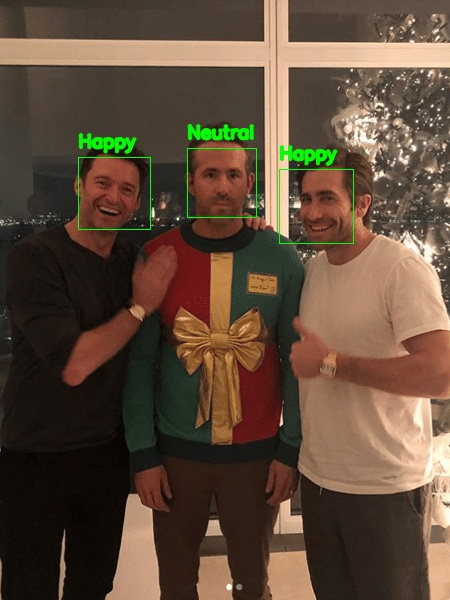

In [97]:
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi = image[y:y + h, x:x + w]
  #cv2_imshow(roi)
  roi = cv2.resize(roi, (48, 48))
  #cv2_imshow(roi)
  roi = roi / 255
  roi = np.expand_dims(roi, axis = 0)
  #print(roi.shape)
  prediction = network_loaded.predict(roi)
  #print(prediction)
  cv2.putText(image, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)

display(Image(data=cv2.imencode('.jpg', image)[1].tobytes()))